In [66]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import shap

/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.data_cleaner import filter_top_cpv_categories
%load_ext autoreload
%autoreload 2
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x).replace(',', ' '))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df = pd.read_csv('../data/data_clean.csv')


In [16]:
df

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215400516.0,78885470100018,SIRET,ACOMETAL,788854701.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de charpente,45000000,45200000,45260000,45261000,45200000,2024
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243500667.0,38373211200032,SIRET,UNIVERS,383732112.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Services d'architecture,71000000,71200000,71200000,71200000,71200000,2021
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249710047.0,43387249600016,SIRET,COTRAM B.T.P.,433872496.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de stations d'épuratio...,45000000,45200000,45230000,45232000,45200000,2024
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625480199.0,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552046955.0,...,Code département,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chauf...,50000000,50700000,50720000,50720000,50000000,2024
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200025633.0,47698032100238,SIRET,POMONA EPISAVEURS,476980321.0,...,Code postal,NaN,data.gouv.fr decp-2025-04.json,Produits alimentaires divers,15000000,15800000,15800000,15800000,15000000,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286845,243000643000452024240072,2024240072,Marché,24300064300045,COMMUNAUTE AGGLO NIMES METROPOLE,243000643.0,79386502300055,SIRET,SERVICES MAINTENANCE ENERGIES,793865023.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Services de réparation et d'entretien de chaud...,50000000,50500000,50530000,50531000,50000000,2024
286846,2133016250001720230231110,20230231110,Marché,21330162500017,COMMUNE D'EYSINES,213301625.0,44010434700032,SIRET,L.T.B. AQUITAINE,440104347.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de peinture,45000000,45400000,45440000,45442000,45400000,2023
286847,25440109400068202323_006_02,202323_006_02,Marché,25440109400068,SYNDICAT MIXTE ATLANTIC'EAU,254401094.0,42856174000138,SIRET,CISE TP,428561740.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux relatifs aux conduites d'alimentation ...,45000000,45200000,45230000,45232000,45200000,2023
286848,219711132000152022I772-4,2022I772-4,Marché,21971113200015,COMMUNE DU GOSIER,219711132.0,41347003000029,SIRET,SOCIETE GUADELOUPEENNE DE TRAVAUX D'ENVIRONNEMENT,413470030.0,...,Code postal,NaN,data.gouv.fr decp-2025-01.json,Location de faucheuses ou de matériel agricole...,77000000,77100000,77110000,77112000,77000000,2022


In [17]:
df = filter_top_cpv_categories(df, top_n=40, cpv_column='codeCPV_2_3')

Filtered from 86 to 40 CPV categories, keeping 277627 rows out of 286850


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
X = df.drop(columns=['montant'])
y = df['montant']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.preprocess_pipeline import create_pipeline_cat

cat_list = ['marche_sim', 'pred_montant', 'anomalie']
cat = cat_list[1]
pipeline = create_pipeline_cat(cat)

In [21]:
X_train_processed = pipeline.fit_transform(X_train)

In [22]:
X_train_processed

,offres_recues_pipeline__offresRecues,other_num_pipeline__dureeMois,other_num_pipeline__annee,binary_pipeline__sousTraitanceDeclaree,binary_pipeline__origineFrance,binary_pipeline__marcheInnovant,binary_pipeline__idAccordCadre,cat_pipeline__procedure_Appel d'offres ouvert,cat_pipeline__procedure_Appel d'offres restreint,cat_pipeline__procedure_Dialogue compétitif,...,cat_pipeline__codeCPV_2_74000000,cat_pipeline__codeCPV_2_75000000,cat_pipeline__codeCPV_2_77000000,cat_pipeline__codeCPV_2_79000000,cat_pipeline__codeCPV_2_80000000,cat_pipeline__codeCPV_2_85000000,cat_pipeline__codeCPV_2_9000000,cat_pipeline__codeCPV_2_90000000,cat_pipeline__codeCPV_2_92000000,cat_pipeline__codeCPV_2_98000000
0,-0.582201,0.623044,0.435916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.348711,0.623044,-1.382279,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.038354,-0.499067,-0.472957,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.348711,0.902275,0.435916,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.038354,1.159395,0.435916,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222096,-0.038354,-1.524136,1.344341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222097,-0.582201,0.924395,-1.382279,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222098,-1.348711,0.623044,1.344341,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
222099,-0.038354,0.924395,-0.472957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# feature_sets = {
#     "all_features": X_train.columns.tolist(),
#     "top_30_features": top_30_list,
#     "drop_highly_correlated": X_train.drop(high_corr_cols, axis=1).columns.tolist(),
# }

In [62]:
# Compute correlations (this assumes X_train and y_train have matching index)
correlations = X_train_processed.corrwith(y_train_log).abs()

# Sort descending
correlations_sorted = correlations.sort_values(ascending=False)

# Select top N features (e.g., top 30)
top_features = correlations_sorted.head(40).index.tolist()

print(top_features)

['cat_pipeline__typeGroupementOperateurs_Conjoint', 'cat_pipeline__codeCPV_2_15000000', 'cat_pipeline__codeCPV_2_60000000', 'cat_pipeline__nature_Marché', 'cat_pipeline__codeCPV_2_22000000', 'cat_pipeline__procedure_Procédure adaptée', 'cat_pipeline__codeCPV_2_74000000', 'cat_pipeline__codeCPV_2_71000000', 'cat_pipeline__ccag_Pas de CCAG', 'cat_pipeline__nature_Marché de partenariat', 'cat_pipeline__nature_Marché de défense ou de sécurité', 'cat_pipeline__codeCPV_2_80000000', "cat_pipeline__ccag_Maitrise d'œuvre", 'cat_pipeline__codeCPV_2_32000000', 'cat_pipeline__typeGroupementOperateurs_Pas de groupement', 'cat_pipeline__procedure_Marché passé sans publicité ni mise en concurrence préalable', 'cat_pipeline__formePrix_Forfaitaire', 'cat_pipeline__codeCPV_2_98000000', 'cat_pipeline__procedure_Procédure avec négociation', 'cat_pipeline__codeCPV_2_72000000', 'cat_pipeline__codeCPV_2_66000000', 'cat_pipeline__codeCPV_2_9000000', 'cat_pipeline__codeCPV_2_92000000', 'cat_pipeline__codeCPV_2

In [48]:
top_features =
['cat_pipeline__typeGroupementOperateurs_Conjoint', 'cat_pipeline__codeCPV_2_15000000',
 'cat_pipeline__codeCPV_2_60000000', 'cat_pipeline__nature_Marché',
 'cat_pipeline__codeCPV_2_22000000', 'cat_pipeline__procedure_Procédure adaptée',
 'cat_pipeline__codeCPV_2_74000000', 'cat_pipeline__codeCPV_2_71000000',
 'cat_pipeline__ccag_Pas de CCAG', 'cat_pipeline__nature_Marché de partenariat',
 'cat_pipeline__nature_Marché de défense ou de sécurité', 'cat_pipeline__codeCPV_2_80000000',
 "cat_pipeline__ccag_Maitrise d'œuvre", 'cat_pipeline__codeCPV_2_32000000',
 'cat_pipeline__typeGroupementOperateurs_Pas de groupement',
 'cat_pipeline__procedure_Marché passé sans publicité ni mise en concurrence préalable',
 'cat_pipeline__formePrix_Forfaitaire', 'cat_pipeline__codeCPV_2_98000000',
 'cat_pipeline__procedure_Procédure avec négociation', 'cat_pipeline__codeCPV_2_72000000',
 'cat_pipeline__codeCPV_2_66000000', 'cat_pipeline__codeCPV_2_9000000',
 'cat_pipeline__codeCPV_2_92000000', 'cat_pipeline__codeCPV_2_45000000',
 'cat_pipeline__codeCPV_2_75000000']

SyntaxError: invalid syntax (71659508.py, line 1)

In [49]:
# Optional: define multiple feature sets if you're experimenting
feature_sets = {
    # "all_features": X_train.columns.tolist(),
    # "custom_subset": ['feature1', 'feature2', ...],
    "top_30": top_features,
}

results = []

for name, features in feature_sets.items():
    # Select feature subset
    X_subset = X_train_processed[features]

    # Split data
    X_tr, X_val, y_tr, y_val = train_test_split(X_subset, y_train_log, test_size=0.2, random_state=42)

    # Initialize model
    model = HistGradientBoostingRegressor(random_state=42)

    # Train model
    model.fit(X_tr, y_tr)

    # Predict
    y_pred = model.predict(X_val)

    # Evaluate
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        "feature_set": name,
        "mse": mse,
        "r2": r2
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)

  feature_set  mse  r2
0      top_30    1   0


In [33]:
y_train_log = np.log1p(y_train)
# Train model on y_train_log, then

<Axes: >

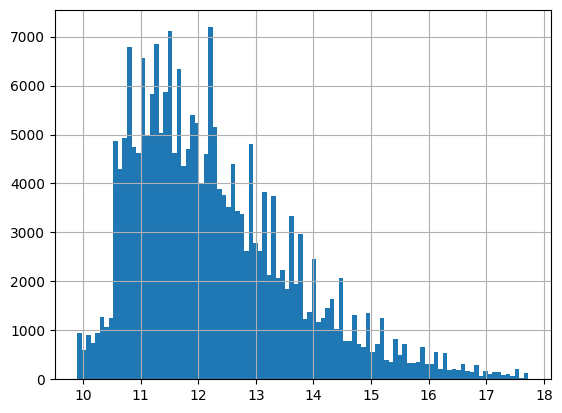

In [34]:

y_train_log.hist(bins=100)

In [32]:
y_train_log

816      11
246012   11
120260   12
204474   12
40084    15
         ..
123929   12
267792   13
136359   11
151787   13
126074   13
Name: montant, Length: 222101, dtype: float64

In [36]:
print("Predicted log std:", y_pred_log.std())

Predicted log std: 1462510.9845083836


<Axes: >

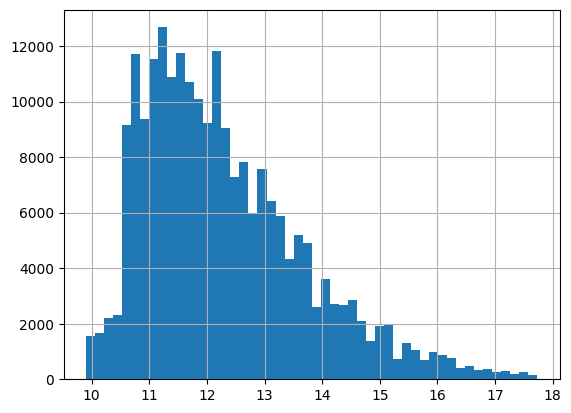

In [37]:
y_train_log.hist(bins=50)

In [41]:
X_train_processed.describe().T.sort_values('max', ascending=False).round(2)

,count,mean,std,min,25%,50%,75%,max
offres_recues_pipeline__offresRecues,222 101,0,1,-1,-1,-0,-0,7
other_num_pipeline__dureeMois,222 101,0,1,-3,-0,0,1,4
other_num_pipeline__annee,222 101,-0,1,-4,-0,0,0,1
cat_pipeline__codeCPV_2_92000000,222 101,0,0,0,0,0,0,1
cat_pipeline__codeCPV_2_18000000,222 101,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
cat_pipeline__typeGroupementOperateurs_Pas de groupement,222 101,1,0,0,1,1,1,1
cat_pipeline__typeGroupementOperateurs_Solidaire,222 101,0,0,0,0,0,0,1
cat_pipeline__tauxAvance_cat_large_advance,222 101,0,0,0,0,0,0,1
cat_pipeline__tauxAvance_cat_medium_advance,222 101,0,0,0,0,0,0,1


# XG Boost

In [51]:
X_subset = X_train_processed[top_features]

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_subset, y_train_log, test_size=0.2, random_state=42)


In [52]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)
model.fit(X_tr, y_tr, )
y_pred_log = model.predict(X_val)

In [53]:
# Log-space metrics
mse_log = mean_squared_error(y_val, y_pred_log)
r2_log = r2_score(y_val, y_pred_log)

# Inverse transform
y_pred = np.expm1(np.clip(y_pred_log, 0, 20))  # clip to avoid overflow

# Real-space metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Log MSE: {mse_log:.2f}, Log R²: {r2_log:.2f}")
print(f"Real MSE: {mse:.2f}, Real R²: {r2:.2f}")

Log MSE: 1.49, Log R²: 0.24
Real MSE: 285739526473.99, Real R²: -144943691843.83


In [54]:
y_pred = np.expm1(np.clip(y_pred_log, 0, 20))
mdape = np.median(np.abs((y_val - y_pred) / y_val)) * 100
print(f"MdAPE: {mdape:.2f}%")

MdAPE: 1524391.22%


In [55]:
print("Min pred_log:", y_pred_log.min())
print("Max pred_log:", y_pred_log.max())

Min pred_log: 10.851101
Max pred_log: 16.076906


In [56]:
print(y_val.describe())
print("Min y_val:", y_val.min())
print("Max y_val:", y_val.max())
print("Median y_val:", y_val.median())
print("Zero or near-zero values in y_val:", (y_val < 1).sum())

count   44 421
mean        12
std          1
min         10
25%         11
50%         12
75%         13
max         18
Name: montant, dtype: float64
Min y_val: 9.90353755128617
Max y_val: 17.72753358339242
Median y_val: 12.02194545956858
Zero or near-zero values in y_val: 0


In [57]:
# Skip expm1 — you're already in log-space
mse = mean_squared_error(y_val, y_pred_log)
r2 = r2_score(y_val, y_pred_log)
mdape = np.median(np.abs((y_val - y_pred_log) / y_val)) * 100

print(f"Log MSE: {mse:.2f}, R²: {r2:.2f}, MdAPE: {mdape:.2f}%")

Log MSE: 1.49, R²: 0.24, MdAPE: 6.37%


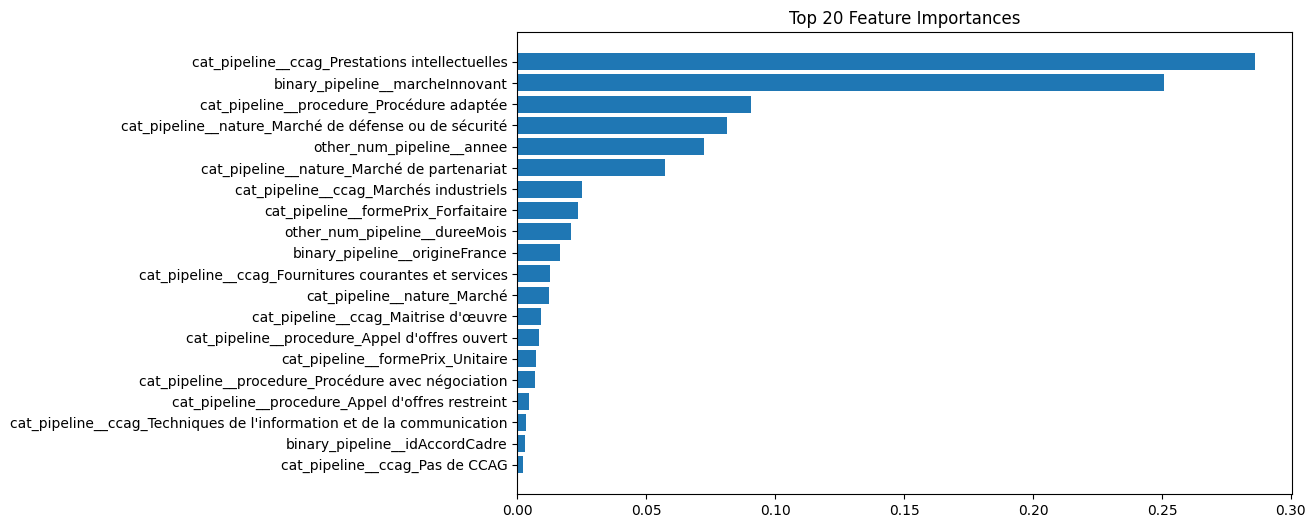

In [59]:
importances = model.feature_importances_
features = X_train_processed.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx[-20:])), importances[sorted_idx][-20:])
plt.yticks(range(len(sorted_idx[-20:])), features[sorted_idx][-20:])
plt.title("Top 20 Feature Importances")
plt.show()

In [63]:
features = [
    'cat_pipeline__codeCPV_2_15000000',
     'cat_pipeline__codeCPV_2_60000000',
     'cat_pipeline__codeCPV_2_22000000', 'cat_pipeline__procedure_Procédure adaptée',
     'cat_pipeline__codeCPV_2_74000000', 'cat_pipeline__codeCPV_2_71000000',
     'cat_pipeline__nature_Marché de partenariat',
     'cat_pipeline__nature_Marché de défense ou de sécurité', 'cat_pipeline__codeCPV_2_80000000',
     'cat_pipeline__codeCPV_2_32000000',
     'cat_pipeline__codeCPV_2_98000000',
      'cat_pipeline__codeCPV_2_72000000',
     'cat_pipeline__codeCPV_2_66000000', 'cat_pipeline__codeCPV_2_9000000',
     'cat_pipeline__codeCPV_2_92000000', 'cat_pipeline__codeCPV_2_45000000',
     'cat_pipeline__codeCPV_2_75000000',
     'cat_pipeline__codeCPV_2_77000000', 'cat_pipeline__codeCPV_2_31000000',
     'cat_pipeline__codeCPV_2_30000000', 'cat_pipeline__codeCPV_2_79000000',
     'cat_pipeline__ccag_Marchés industriels', 'cat_pipeline__codeCPV_2_42000000',
     'cat_pipeline__codeCPV_2_50000000', 'binary_pipeline__marcheInnovant'
     ]


In [64]:
X_train_selected = X_train_processed[features]

# Initialize the model
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
model.fit(X_train_selected, y_train_log)

# Predict on training set (or validation set if you split it)
y_pred_log = model.predict(X_train_selected)

# Evaluate in log space
mse_log = mean_squared_error(y_train_log, y_pred_log)
r2_log = r2_score(y_train_log, y_pred_log)
mdape_log = np.median(np.abs((y_train_log - y_pred_log) / y_train_log)) * 100

print(f"Log MSE: {mse_log:.2f}, Log R²: {r2_log:.2f}, MdAPE: {mdape_log:.2f}%")

Log MSE: 1.66, Log R²: 0.16, MdAPE: 6.83%


# SHAP

In [67]:
# Train on all features first
model = XGBRegressor(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)

model.fit(X_train_processed, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [68]:
# Create SHAP explainer
explainer = shap.Explainer(model, X_train_processed)

# Compute SHAP values for training data
shap_values = explainer(X_train_processed)

100%|===================| 222046/222101 [15:27<00:00]        

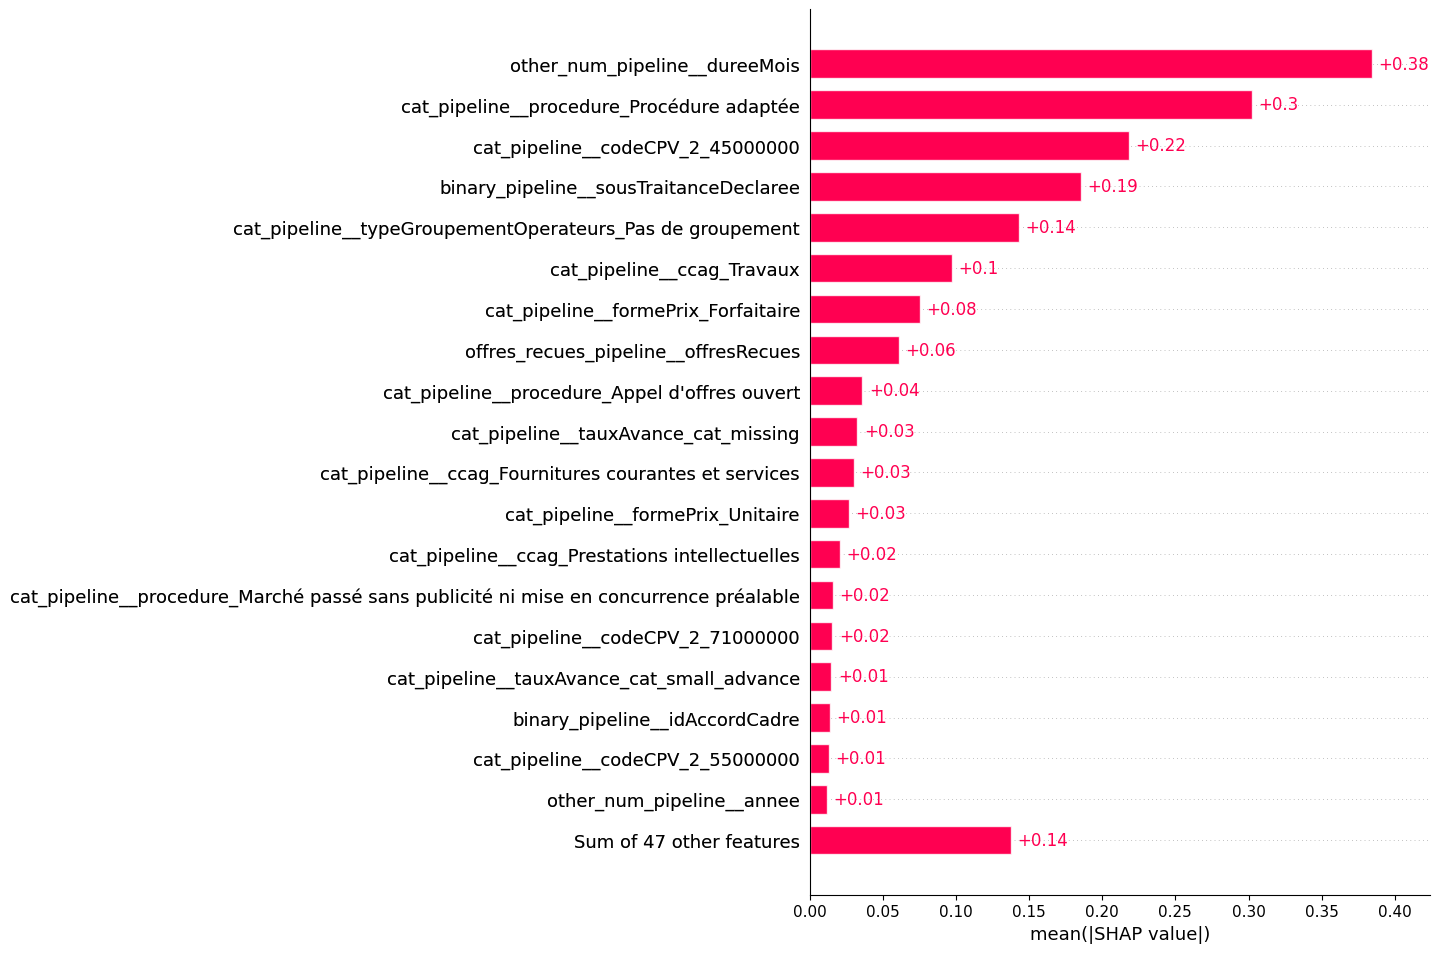

In [69]:
shap.plots.bar(shap_values, max_display=20)

In [72]:
# Get mean absolute SHAP values
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_names = X_train_processed.columns

# Create a DataFrame of importances
importance_df = (
    pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
    .sort_values(by='importance', ascending=False)
)

# Pick top N features
top_n = 8
top_features = importance_df['feature'].iloc[:top_n].tolist()

In [71]:
importance_df

,feature,importance
1,other_num_pipeline__dureeMois,0
11,cat_pipeline__procedure_Procédure adaptée,0
47,cat_pipeline__codeCPV_2_45000000,0
3,binary_pipeline__sousTraitanceDeclaree,0
27,cat_pipeline__typeGroupementOperateurs_Pas de ...,0
...,...,...
21,cat_pipeline__ccag_Marchés industriels,0
64,cat_pipeline__codeCPV_2_92000000,0
13,cat_pipeline__nature_Marché,0
14,cat_pipeline__nature_Marché de défense ou de s...,0


In [73]:
X_top = X_train_processed[top_features]
model_top = XGBRegressor(random_state=42)
model_top.fit(X_top, y_train_log)

# Evaluate
y_pred_top = model_top.predict(X_top)
mse = mean_squared_error(y_train_log, y_pred_top)
r2 = r2_score(y_train_log, y_pred_top)
mdape = np.median(np.abs((y_train_log - y_pred_top) / y_train_log)) * 100

print(f"Top-{top_n} SHAP feature model:")
print(f"Log MSE: {mse:.2f}, R²: {r2:.2f}, MdAPE: {mdape:.2f}%")

Top-8 SHAP feature model:
Log MSE: 1.20, R²: 0.39, MdAPE: 5.56%


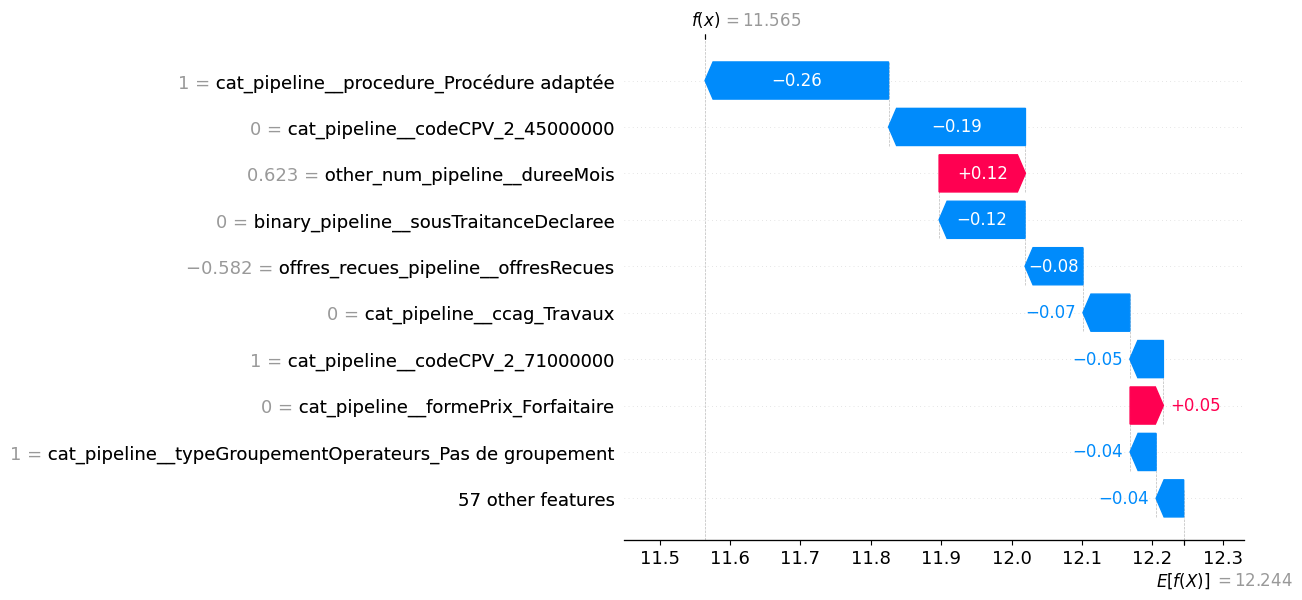

In [74]:
shap.plots.waterfall(shap_values[0])  # First example

# Classifier

In [96]:
y_binned = pd.qcut(y_train, q=8, labels=False)
y_test_binned = pd.qcut(y_test, q=8, labels=False)

In [93]:
from xgboost import XGBClassifier
model_cls = XGBClassifier()
model_cls.fit(X_train_processed, y_binned)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_binned, model_cls.predict(X_train_processed)))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37     27763
           1       0.28      0.40      0.33     27763
           2       0.34      0.17      0.22     27762
           3       0.30      0.18      0.23     27773
           4       0.33      0.16      0.21     27823
           5       0.28      0.29      0.29     27692
           6       0.32      0.46      0.38     28799
           7       0.54      0.62      0.58     26726

    accuracy                           0.34    222101
   macro avg       0.34      0.34      0.32    222101
weighted avg       0.34      0.34      0.32    222101



In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test_binned, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [55526, 44421]

In [100]:
X_test_processed = pipeline.transform(X_test)

/home/julie/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [101]:
from sklearn.metrics import confusion_matrix

y_pred = model_cls.predict(X_test)

sns.heatmap(confusion_matrix(y_test_binned, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:uid: object, id: object, nature: object, acheteur_nom: object, titulaire_id: object, titulaire_typeIdentifiant: object, titulaire_nom: object, objet: object, codeCPV: object, procedure: object, dateNotification: object, datePublicationDonnees: object, formePrix: object, ccag: object, typeGroupementOperateurs: object, lieuExecution_code: object, lieuExecution_typeCode: object, idAccordCadre: object, source_open_data: object, codeCPV_FR: object